<a href="https://colab.research.google.com/github/SaswatD27/SyrDataSuppression/blob/main/ACSAnalysis1_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#import libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
#import pipeline_dp as pdp
import math
import random
import data_tools_syr as syr
from sklearn.tree import DecisionTreeClassifier 
from sklearn.model_selection import train_test_split 
from sklearn import metrics 

##Analysis Tools

In [ ]:
def zeroProb(p):
#                    this is the chance of "staying put at 0"
  if random.random()<(1.0 - p)/(1.0 + p):
    return 0
  else:
    return 1
    # Coin flip to determine if the result is negative or positive.
    # This only applies when we "leave 0."
def signProb():
  if random.random() < 0.5:
    return -1
  else:
    return 1

def twoSidedGeoDist(p):
#      (1) Did we "leave 0"? [Y=1|N=0]        (3) +/-
  return zeroProb(p) * np.random.geometric(1-p) * signProb()
def mech_disclaplace(eps):
  return twoSidedGeoDist(math.e**(-eps))
#--------------------

#----- Adding DP to Hist ----
def add_dp_hist(counts):
  dp_counts=[]
  for i in range(len(counts)):
    dp_counts.append(counts[i]+twoSidedGeoDist(math.e**(-eps)))
  return [abs(x) for x in dp_counts]
#----------------------------

#----- Multiple Runs of DP and extraction of worst runs ---

#----------------------------------------------------------

#----- Merge Columns ----------- (Probably useless, let's see)
def suppress_merge(df,colvec): #colvec: list of columns to merge
  data_suppressed=df.copy()
  data_suppressed=data_suppressed.drop(columns=colvec)
  #Then add a hybrid column with tuples
  #A column needs a name!
  colname=""
  for c in colvec:
    colname=colname+str(c)
  data_suppressed[str(colname)]=df[colvec].astype(str).agg('-'.join, axis=1)
  return data_suppressed
#-----------------------

#----- Binning ----------
def data_col_bin(df,col,wid):#col - index of the column, wid - desired width
  min_l=min(df[col])
  max_l=max(df[col])
  bins=[]
  for i in range(min_l//wid,max_l//wid):
    bin.append([i,i+wid])
  df_bin=df.copy()
  df_bin=df[col]
  return df_bin
#------------------------

#----- Merging Categories for a categorical attribute----

#--------------------------------------------------------

#----- Fairness Error ----
def fair_err(hist):
  return max(hist)-min(hist)
#-------------------------

#----- Randomly k anonymise by merging----
def merge_random(hist,col,k): #Merges a given bin/bucket with another bin
  hist1=list(hist)
  col2=0
  #print(hist)
  #print(hist[col]+hist[col2])
  while hist[col]+hist[col2]<k:
    col2=random.choice([*range(0,col),*range(col+1,len(hist))])
  hist1.append(hist[col]+hist[col2])
  del hist1[col]
  del hist1[col2]
  return hist1

def k_anonymise_rand(hist,k): #k anonymises a histogram with random bin merging
  hist=np.array(hist)
  #print(hist<k)
  while any(hist<k):
    i=np.where(hist<k)
    #print('i=',i[0][0])
    hist=np.array(merge_random(hist,i[0][0],k))
  return hist
#-------------------------------

#----- k anonymise and spread ---------
def spread_random(hist,cols,k): #Merges a given bin/bucket with another bin
  hist1=list(hist)
  col=cols[0]
  if col == 0:
    col2=1
  else:
    col2=0
  #print(hist)
  #print(hist[col]+hist[col2])
  while (hist[col]+hist[col2]<k) or (col2 in cols):
    col2=random.choice([*range(0,len(hist))])
    #print('lol')
  #print(col2)
  val=(hist[col]+hist[col2])/2
  hist1[col2]=val
  hist1[col]=val
  return hist1

def spread_k_anonymise(hist,k): #k anonymises a histogram with random bin merging
  hist=np.array(hist)
  #print(hist<k)
  while any(hist<k):
    #print('lel')
    i=np.where(hist<k)
    #print(i)
    #print('i=',i[0][0])
    hist=np.array(spread_random(hist,i[0],k))
  return hist.astype(int)
#--------------------------------------

#----- Suppress by Omission ----
def supp_omit(hist, thres):
  hist1=list(hist)
  for i in range(len(hist1)):
    if hist1[i]<thres:
      hist1[i]=0
  return hist1
#-------------------------------

#----- k anon adj merge ------#incomplete
def spread_bins(hist,col1,col2):
  hist1=list(hist)
  hist1[col1]=(hist[col1]+hist[col2])/2
  hist1[col2]=float(hist1[col1])
  return hist1

def spread_adjacent(hist,col,k): #Merges a given bin/bucket with adjacent bins
  hist1=list(hist)
  if col==len(hist)-1:
    hist1=list(spread_bins(hist1,col,col-1))
  elif col==0:
    hist1=list(spread_bins(hist1,col,col+1))
  else:
    if hist1[col-1]>hist1[col+1]:
      hist1=list(spread_bins(hist1,col,col-1))
    else:
      hist1=list(spread_bins(hist1,col,col+1))
  return hist1

def adj_k_anonymise(hist,k):
  hist=np.array(hist)
  l=0
  while any(hist<k):
    l+=1
    print(l)
    i=np.where(hist<k)
    print(i)
    for j in i[0]:
      spread_adjacent(hist,j,k)
  return hist.astype(int)
#-----------------------------

#----- Times DP is beaten ----
#Perhaps write it in the notebook itself
#-----------------------------

Correlation. k as percentiles.

# Import Dataset

Packages for rep on a map. Join with another table for counties. Maybe try for different PUMAs

In [ ]:
#import dataset - tx
df=pd.read_csv("outlier_acs_2019.csv")

In [ ]:
df

,Unnamed: 0,PUMA,GQ,OWNERSHP,FAMSIZE,NCHILD,AGE,SEX,MARST,RACE,...,INCTOT_DECILE,POVERTY,DENSITY,VETDISAB,DIFFREM,DIFFPHYS,DIFFEYE,DIFFHEAR,HHWT,PERWT
0,37,1-1301,4,0,1,0,18,2,6,8,...,0,0,2731.2,0,1,1,1,1,79.0,79.0
1,84,1-1301,4,0,1,0,27,1,6,1,...,3,116,2731.2,0,1,1,1,1,5.0,5.0
2,85,1-1301,3,0,1,0,74,2,5,2,...,3,0,2731.2,0,1,2,1,1,19.0,19.0
3,95,1-1301,4,0,1,0,22,1,6,1,...,0,0,2731.2,0,1,1,1,1,10.0,10.0
4,152,1-1301,4,0,1,0,18,2,6,1,...,0,0,2731.2,0,1,1,1,1,85.0,85.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27248,3077532,51-1301,1,1,4,0,10,1,6,1,...,9,501,11162.8,0,1,1,1,1,120.0,149.0
27249,3077595,51-1301,1,2,2,0,19,1,6,1,...,0,187,11162.8,0,1,1,1,1,366.0,365.0
27250,3077596,51-1301,1,2,2,1,56,2,5,1,...,4,187,11162.8,0,1,1,1,1,366.0,316.0
27251,3077798,51-1301,1,1,1,0,67,2,2,1,...,8,501,11162.8,0,1,1,1,1,63.0,62.0


#Marginal Query 1

In [ ]:
mar_df_1=pd.DataFrame()

In [ ]:
#3-Way Marginal Query
#for i in range(7):
#  df2=df1[(df1['AGE']>i*10) & (df1['AGE']<=(i+1)*10) & (df1['SEX']==2) & (df1['RACE']==2)]# & (df['MARST']==2)]# & (df['hours-per-week'] >30)]# & (df['native-country']=='United-States')]
#  #print(df2.head())
#  mar_df_1=mar_df_1.append(df2, ignore_index=True)
  #print(mar_df.head())
mar_df_1=df.groupby(['PUMA','RACE','SEX'])

In [ ]:
counts_1=mar_df_1.count()['GQ'].values.tolist()
counts_1.sort()
print(counts_1)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 8, 8, 8, 8, 8, 9, 9, 9, 9, 10, 10, 10, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 11, 11, 12, 12, 12, 12, 12, 12, 12, 12, 13, 13, 13, 14, 14, 14, 14, 15, 15, 15, 16, 16, 17, 17, 17, 17, 17, 17, 18, 18, 18, 18, 18, 20, 20, 21, 22, 22, 22, 22, 22, 22, 22, 23, 23, 23, 23, 24, 25, 25, 26, 26, 27, 27, 27, 28, 29, 29, 29, 30, 30, 31, 31, 32, 33, 33, 33, 33, 34, 35, 36, 36, 37, 37, 38, 39, 39, 41, 42, 43, 46, 47, 47, 51, 52, 56, 57, 58, 66, 66, 67, 70, 73, 82, 96, 97, 101, 105, 106, 107, 108, 109, 113, 115, 117, 120, 122, 127, 129, 132, 133, 141, 151, 151, 155, 156, 161, 162, 175, 176, 178, 179, 184, 193, 197, 206, 212, 265, 297, 310, 314, 317, 329, 339

[44,44,48,47,47,42,42]

In [ ]:
#Calculating k with percentiles
sum_counts_1=sum(counts_1)
k_95=counts_1[int(len(counts_1)*0.05)]
print(k_95)
k_90=counts_1[int(len(counts_1)*0.1)]
print(k_90)
k_87=counts_1[int(len(counts_1)*0.13)]
print(k_87)
k_80=counts_1[int(len(counts_1)*0.2)]
print(k_80)

1
1
2
2


##Suppression by Omission

In [ ]:
counts_1_redact_95=syr.supp_omit(counts_1,k_95)
print(counts_1_redact_95)
#l_1 Error
err_counts_1_redact_95=sum(abs(np.array(counts_1_redact_95)-counts_1))
print("l_1 error: ",err_counts_1_redact_95)
#Fairness Error
fair_err_counts_1_redact_95=max(abs(np.array(counts_1_redact_95)-counts_1))-min(abs(np.array(counts_1_redact_95)-counts_1))
print("Fairness error: ",fair_err_counts_1_redact_95)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 8, 8, 8, 8, 8, 9, 9, 9, 9, 10, 10, 10, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 11, 11, 12, 12, 12, 12, 12, 12, 12, 12, 13, 13, 13, 14, 14, 14, 14, 15, 15, 15, 16, 16, 17, 17, 17, 17, 17, 17, 18, 18, 18, 18, 18, 20, 20, 21, 22, 22, 22, 22, 22, 22, 22, 23, 23, 23, 23, 24, 25, 25, 26, 26, 27, 27, 27, 28, 29, 29, 29, 30, 30, 31, 31, 32, 33, 33, 33, 33, 34, 35, 36, 36, 37, 37, 38, 39, 39, 41, 42, 43, 46, 47, 47, 51, 52, 56, 57, 58, 66, 66, 67, 70, 73, 82, 96, 97, 101, 105, 106, 107, 108, 109, 113, 115, 117, 120, 122, 127, 129, 132, 133, 141, 151, 151, 155, 156, 161, 162, 175, 176, 178, 179, 184, 193, 197, 206, 212, 265, 297, 310, 314, 317, 329, 339

In [ ]:
counts_1_redact_90=syr.supp_omit(counts_1,k_90)
print(counts_1_redact_90)
err_counts_1_redact_90=sum(abs(np.array(counts_1_redact_90)-counts_1))
print("l_1 error: ",err_counts_1_redact_90)
#Fairness Error
fair_err_counts_1_redact_90=max(abs(np.array(counts_1_redact_90)-counts_1))-min(abs(np.array(counts_1_redact_90)-counts_1))
print("Fairness error: ",fair_err_counts_1_redact_90)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 8, 8, 8, 8, 8, 9, 9, 9, 9, 10, 10, 10, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 11, 11, 12, 12, 12, 12, 12, 12, 12, 12, 13, 13, 13, 14, 14, 14, 14, 15, 15, 15, 16, 16, 17, 17, 17, 17, 17, 17, 18, 18, 18, 18, 18, 20, 20, 21, 22, 22, 22, 22, 22, 22, 22, 23, 23, 23, 23, 24, 25, 25, 26, 26, 27, 27, 27, 28, 29, 29, 29, 30, 30, 31, 31, 32, 33, 33, 33, 33, 34, 35, 36, 36, 37, 37, 38, 39, 39, 41, 42, 43, 46, 47, 47, 51, 52, 56, 57, 58, 66, 66, 67, 70, 73, 82, 96, 97, 101, 105, 106, 107, 108, 109, 113, 115, 117, 120, 122, 127, 129, 132, 133, 141, 151, 151, 155, 156, 161, 162, 175, 176, 178, 179, 184, 193, 197, 206, 212, 265, 297, 310, 314, 317, 329, 339

In [ ]:
counts_1_redact_87=syr.supp_omit(counts_1,k_87)
print(counts_1_redact_87)
err_counts_1_redact_87=sum(abs(np.array(counts_1_redact_87)-counts_1))
print("l_1 error: ",err_counts_1_redact_87)
#Fairness Error
fair_err_counts_1_redact_87=max(abs(np.array(counts_1_redact_87)-counts_1))-min(abs(np.array(counts_1_redact_87)-counts_1))
print("Fairness error: ",fair_err_counts_1_redact_87)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 8, 8, 8, 8, 8, 9, 9, 9, 9, 10, 10, 10, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 11, 11, 12, 12, 12, 12, 12, 12, 12, 12, 13, 13, 13, 14, 14, 14, 14, 15, 15, 15, 16, 16, 17, 17, 17, 17, 17, 17, 18, 18, 18, 18, 18, 20, 20, 21, 22, 22, 22, 22, 22, 22, 22, 23, 23, 23, 23, 24, 25, 25, 26, 26, 27, 27, 27, 28, 29, 29, 29, 30, 30, 31, 31, 32, 33, 33, 33, 33, 34, 35, 36, 36, 37, 37, 38, 39, 39, 41, 42, 43, 46, 47, 47, 51, 52, 56, 57, 58, 66, 66, 67, 70, 73, 82, 96, 97, 101, 105, 106, 107, 108, 109, 113, 115, 117, 120, 122, 127, 129, 132, 133, 141, 151, 151, 155, 156, 161, 162, 175, 176, 178, 179, 184, 193, 197, 206, 212, 265, 297, 310, 314, 317, 329, 339

##Suppression by $k$-Anonymity (Adj)

In [ ]:
counts_1_adj_95=syr.adj_k_anonymise(counts_1,k_95)
print(counts_1_adj_95)
#l_1 Error
err_counts_1_adj_95=sum(abs(np.array(counts_1_adj_95)-counts_1))
print("l_1 error: ",err_counts_1_adj_95)
#Fairness Error
fair_err_counts_1_adj_95=max(abs(np.array(counts_1_adj_95)-counts_1))-min(abs(np.array(counts_1_adj_95)-counts_1))
print("Fairness error: ",fair_err_counts_1_adj_95)

[   1    1    1    1    1    1    1    1    1    1    1    1    1    1
    1    1    1    1    1    1    1    1    1    1    1    1    1    1
    1    1    1    1    1    1    1    1    1    2    2    2    2    2
    2    2    2    2    2    2    2    2    2    2    2    2    2    2
    2    2    2    2    2    3    3    3    3    3    3    3    3    3
    3    3    3    3    3    3    3    3    3    3    3    3    3    3
    4    4    4    4    4    4    4    4    4    4    4    4    5    5
    5    5    5    5    5    5    6    6    6    6    6    6    6    6
    6    7    7    7    8    8    8    8    8    9    9    9    9   10
   10   10   10   10   10   10   10   11   11   11   11   11   11   11
   12   12   12   12   12   12   12   12   13   13   13   14   14   14
   14   15   15   15   16   16   17   17   17   17   17   17   18   18
   18   18   18   20   20   21   22   22   22   22   22   22   22   23
   23   23   23   24   25   25   26   26   27   27   27   28   29   29
   29 

Text(0, 0.5, 'Number of People')

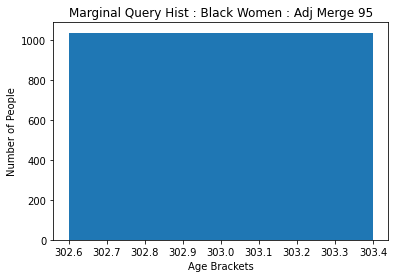

In [ ]:
plt.bar(len(counts_1),counts_1_adj_95)
plt.title('Marginal Query Hist : Black Women : Adj Merge 95')
plt.xlabel('Age Brackets')
plt.ylabel('Number of People')

In [ ]:
counts_1_adj_90=syr.adj_k_anonymise(counts_1,k_90)
print(counts_1_adj_90)
err_counts_1_adj_90=sum(abs(counts_1_adj_90-counts_1))
print(err_counts_1_adj_90)
#l_1 Error
err_counts_1_adj_90=sum(abs(np.array(counts_1_adj_90)-counts_1))
print("l_1 error: ",err_counts_1_adj_90)
#Fairness Error
fair_err_counts_1_adj_90=max(abs(np.array(counts_1_adj_90)-counts_1))-min(abs(np.array(counts_1_adj_90)-counts_1))
print("Fairness error: ",fair_err_counts_1_adj_90)

[   1    1    1    1    1    1    1    1    1    1    1    1    1    1
    1    1    1    1    1    1    1    1    1    1    1    1    1    1
    1    1    1    1    1    1    1    1    1    2    2    2    2    2
    2    2    2    2    2    2    2    2    2    2    2    2    2    2
    2    2    2    2    2    3    3    3    3    3    3    3    3    3
    3    3    3    3    3    3    3    3    3    3    3    3    3    3
    4    4    4    4    4    4    4    4    4    4    4    4    5    5
    5    5    5    5    5    5    6    6    6    6    6    6    6    6
    6    7    7    7    8    8    8    8    8    9    9    9    9   10
   10   10   10   10   10   10   10   11   11   11   11   11   11   11
   12   12   12   12   12   12   12   12   13   13   13   14   14   14
   14   15   15   15   16   16   17   17   17   17   17   17   18   18
   18   18   18   20   20   21   22   22   22   22   22   22   22   23
   23   23   23   24   25   25   26   26   27   27   27   28   29   29
   29 

In [ ]:
counts_1_adj_87=syr.adj_k_anonymise(counts_1,k_87)
print(counts_1_adj_87)
err_counts_1_adj_87=sum(abs(counts_1_adj_87-counts_1))
print(err_counts_1_adj_87)
#l_1 Error
err_counts_1_adj_87=sum(abs(np.array(counts_1_adj_87)-counts_1))
print("l_1 error: ",err_counts_1_adj_87)
#Fairness Error
fair_err_counts_1_adj_87=max(abs(np.array(counts_1_adj_87)-counts_1))-min(abs(np.array(counts_1_adj_87)-counts_1))
print("Fairness error: ",fair_err_counts_1_adj_87)

KeyboardInterrupt: ignored

In [ ]:
counts_1_adj_80=syr.adj_k_anonymise(counts_1,k_80)
print(counts_1_adj_80)
#l_1 Error
err_counts_1_adj_80=sum(abs(np.array(counts_1_adj_80)-counts_1))
print("l_1 error: ",err_counts_1_adj_80)
#Fairness Error
fair_err_counts_1_adj_80=max(abs(np.array(counts_1_adj_80)-counts_1))-min(abs(np.array(counts_1_adj_80)-counts_1))
print("Fairness error: ",fair_err_counts_1_adj_80)

## Applying the Discrete Laplace Mechanism

### $\epsilon=1$

In [ ]:
#eps=1
errs_dp_1_counts_1=[]
fair_errs_dp_1_counts_1=[]
for i in range(1000):
  dp_counts_1=syr.add_dp_hist(counts_1,eps=1)
  errs_dp_1_counts_1.append(sum(abs(np.array(dp_counts_1)-counts_1)))
  fair_errs_dp_1_counts_1.append(max(abs(np.array(dp_counts_1)-counts_1))-min(abs(np.array(dp_counts_1)-counts_1)))

In [ ]:
print(errs_dp_1_counts_1)
print(fair_errs_dp_1_counts_1)

[292, 227, 236, 219, 215, 279, 281, 233, 251, 226, 214, 242, 221, 234, 265, 267, 236, 247, 236, 226, 273, 239, 244, 269, 233, 261, 275, 264, 228, 280, 235, 254, 246, 243, 244, 228, 246, 258, 230, 240, 228, 222, 218, 263, 244, 254, 262, 229, 264, 264, 237, 240, 272, 257, 240, 243, 237, 255, 212, 231, 270, 233, 254, 256, 257, 260, 265, 241, 240, 191, 225, 250, 256, 218, 239, 266, 243, 231, 246, 227, 240, 231, 258, 232, 216, 245, 249, 252, 230, 243, 267, 257, 230, 262, 242, 258, 270, 203, 268, 276, 292, 272, 227, 260, 256, 248, 275, 239, 249, 268, 245, 257, 238, 252, 256, 241, 247, 243, 246, 281, 236, 213, 268, 246, 261, 230, 300, 267, 246, 279, 250, 231, 241, 251, 231, 244, 226, 234, 200, 244, 254, 264, 250, 262, 211, 242, 249, 250, 260, 247, 279, 231, 271, 225, 239, 227, 260, 252, 245, 241, 226, 241, 257, 232, 247, 215, 235, 271, 231, 234, 262, 242, 290, 307, 243, 249, 231, 268, 253, 225, 240, 229, 254, 210, 242, 212, 244, 239, 226, 267, 232, 262, 239, 222, 225, 238, 240, 209, 241, 243,

#### vs Suppression (adj)

In [ ]:
dp_better_1_v_k95_l1=0
for i in errs_dp_1_counts_1:
  if i<err_counts_1_adj_95:
    dp_better_1_v_k95_l1+=1
dp_better_1_v_k95_l1=(dp_better_1_v_k95_l1/1000)*100
print(dp_better_1_v_k95_l1)

0.0


In [ ]:
dp_better_1_v_k95_fair=0
for i in fair_errs_dp_1_counts_1:
  if i<fair_err_counts_1_adj_95:
    dp_better_1_v_k95_fair+=1
dp_better_1_v_k95_fair=(dp_better_1_v_k95_fair/1000)*100
print(dp_better_1_v_k95_fair)

0.0


In [ ]:
dp_better_1_v_k87_l1=0
for i in errs_dp_1_counts_1:
  if i<err_counts_1_adj_87:
    dp_better_1_v_k87_l1+=1
dp_better_1_v_k87_l1=(dp_better_1_v_k87_l1/1000)*100
print(dp_better_1_v_k87_l1)

0.0


In [ ]:
dp_better_1_v_k87_fair=0
for i in fair_errs_dp_1_counts_1:
  if i<fair_err_counts_1_adj_87:
    dp_better_1_v_k87_fair+=1
dp_better_1_v_k87_fair=(dp_better_1_v_k87_fair/1000)*100
print(dp_better_1_v_k87_fair)

0.0


In [ ]:
dp_better_1_v_k80_l1=0
for i in errs_dp_1_counts_1:
  if i<err_counts_1_adj_80:
    dp_better_1_v_k80_l1+=1
dp_better_1_v_k80_l1=(dp_better_1_v_k80_l1/1000)*100
print(dp_better_1_v_k80_l1)

0.0


In [ ]:
dp_better_1_v_k80_fair=0
for i in fair_errs_dp_1_counts_1:
  if i<fair_err_counts_1_adj_80:
    dp_better_1_v_k80_fair+=1
dp_better_1_v_k80_fair=(dp_better_1_v_k80_fair/1000)*100
print(dp_better_1_v_k80_fair)

71.89999999999999


#### Box plots

{'boxes': [<matplotlib.lines.Line2D at 0x7f659d32b910>],
 'caps': [<matplotlib.lines.Line2D at 0x7f659d32d9d0>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f659d331a10>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7f659d3314d0>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7f659d32bf10>,
  <matplotlib.lines.Line2D at 0x7f659d32d490>]}

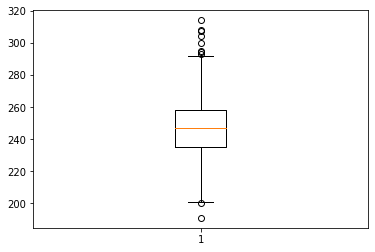

In [ ]:
plt.boxplot(errs_dp_1_counts_1)

{'boxes': [<matplotlib.lines.Line2D at 0x7f659d3082d0>],
 'caps': [<matplotlib.lines.Line2D at 0x7f659d30e350>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f659d296390>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7f659d30ee10>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7f659d308890>,
  <matplotlib.lines.Line2D at 0x7f659d308dd0>]}

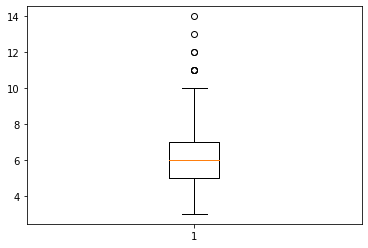

In [ ]:
plt.boxplot(fair_errs_dp_1_counts_1)

### $\epsilon=2$

In [ ]:
#eps=2
errs_dp_2_counts_1=[]
fair_errs_dp_2_counts_1=[]
for i in range(1000):
  dp_counts_1=syr.add_dp_hist(counts_1,eps=2)
  errs_dp_2_counts_1.append(sum(abs(np.array(dp_counts_1)-counts_1)))
  fair_errs_dp_2_counts_1.append(max(abs(np.array(dp_counts_1)-counts_1))-min(abs(np.array(dp_counts_1)-counts_1)))

In [ ]:
print(errs_dp_2_counts_1)
print(fair_errs_dp_2_counts_1)

[95, 80, 72, 85, 82, 87, 81, 91, 101, 84, 73, 78, 84, 94, 81, 73, 80, 83, 94, 87, 81, 91, 85, 92, 94, 67, 89, 63, 90, 82, 73, 87, 76, 78, 82, 70, 74, 93, 65, 76, 84, 81, 85, 89, 95, 77, 82, 83, 92, 72, 80, 82, 76, 70, 77, 78, 86, 85, 73, 86, 65, 68, 76, 85, 91, 92, 93, 89, 73, 72, 75, 80, 95, 75, 83, 66, 92, 87, 76, 94, 76, 76, 68, 83, 84, 83, 72, 80, 96, 83, 76, 85, 82, 82, 80, 66, 79, 85, 84, 79, 77, 79, 72, 71, 100, 73, 90, 85, 72, 99, 77, 74, 79, 62, 96, 79, 82, 84, 74, 70, 64, 73, 101, 80, 83, 93, 78, 91, 72, 82, 101, 94, 74, 89, 78, 81, 73, 64, 65, 90, 69, 74, 84, 85, 83, 78, 74, 95, 72, 60, 92, 94, 62, 89, 74, 82, 82, 94, 80, 94, 72, 85, 82, 78, 94, 86, 92, 74, 88, 94, 80, 76, 96, 75, 72, 89, 95, 83, 85, 89, 99, 88, 84, 95, 75, 92, 78, 83, 92, 93, 72, 88, 76, 75, 69, 90, 65, 67, 88, 80, 74, 89, 79, 89, 77, 93, 63, 74, 86, 97, 69, 69, 78, 80, 76, 76, 83, 81, 78, 78, 72, 68, 73, 81, 85, 87, 72, 74, 80, 81, 79, 83, 87, 74, 86, 92, 80, 94, 86, 86, 87, 84, 81, 86, 80, 78, 83, 80, 88,

#### vs Suppression (adj)

In [ ]:
dp_better_2_v_k95_l1=0
for i in errs_dp_2_counts_1:
  if i<err_counts_1_adj_95:
    dp_better_2_v_k95_l1+=1
dp_better_2_v_k95_l1=(dp_better_2_v_k95_l1/1000)*100
print(dp_better_2_v_k95_l1)

0.0


In [ ]:
dp_better_2_v_k95_fair=0
for i in fair_errs_dp_1_counts_1:
  if i<fair_err_counts_1_adj_95:
    dp_better_2_v_k95_fair+=1
dp_better_2_v_k95_fair=(dp_better_2_v_k95_fair/1000)*100
print(dp_better_2_v_k95_fair)

0.0


In [ ]:
dp_better_2_v_k90_l1=0
for i in errs_dp_2_counts_1:
  if i<err_counts_1_adj_90:
    dp_better_2_v_k90_l1+=1
dp_better_2_v_k90_l1=(dp_better_2_v_k90_l1/1000)*100
print(dp_better_2_v_k90_l1)

0.0


In [ ]:
dp_better_2_v_k90_fair=0
for i in fair_errs_dp_2_counts_1:
  if i<fair_err_counts_1_adj_90:
    dp_better_2_v_k90_fair+=1
dp_better_2_v_k90_fair=(dp_better_2_v_k90_fair/1000)*100
print(dp_better_2_v_k90_fair)

0.0


In [ ]:
dp_better_2_v_k80_l1=0
for i in errs_dp_2_counts_1:
  if i<err_counts_1_adj_80:
    dp_better_2_v_k80_l1+=1
dp_better_2_v_k80_l1=(dp_better_2_v_k80_l1/1000)*100
print(dp_better_2_v_k80_l1)

97.89999999999999


In [ ]:
dp_better_1_v_k95_fair=0
for i in fair_errs_dp_2_counts_1:
  if i<fair_err_counts_1_adj_80:
    dp_better_1_v_k95_fair+=1
dp_better_1_v_k95_fair=(dp_better_1_v_k95_fair/1000)*100
print(dp_better_1_v_k95_fair)

100.0


In [ ]:
dp_better_2_v_k87_l1=0
for i in errs_dp_2_counts_1:
  if i<err_counts_1_adj_87:
    dp_better_2_v_k87_l1+=1
dp_better_2_v_k87_l1=(dp_better_2_v_k87_l1/1000)*100
print(dp_better_2_v_k87_l1)

0.0


In [ ]:
dp_better_2_v_k87_fair=0
for i in fair_errs_dp_2_counts_1:
  if i<fair_err_counts_1_adj_87:
    dp_better_2_v_k87_fair+=1
dp_better_2_v_k87_fair=(dp_better_2_v_k87_fair/1000)*100
print(dp_better_2_v_k87_fair)

29.799999999999997


#### Box plots

{'boxes': [<matplotlib.lines.Line2D at 0x7f659d27eed0>],
 'caps': [<matplotlib.lines.Line2D at 0x7f659d285f90>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f659d28dfd0>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7f659d28da90>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7f659d285510>,
  <matplotlib.lines.Line2D at 0x7f659d285a50>]}

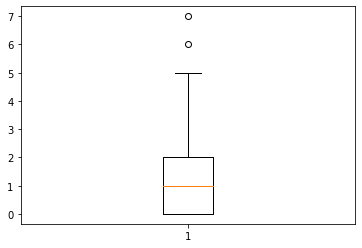

In [ ]:
plt.boxplot(errs_dp_5_counts_1)

{'boxes': [<matplotlib.lines.Line2D at 0x7f659d1f5110>],
 'caps': [<matplotlib.lines.Line2D at 0x7f659d1fd190>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f659d2051d0>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7f659d1fdc50>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7f659d1f56d0>,
  <matplotlib.lines.Line2D at 0x7f659d1f5c10>]}

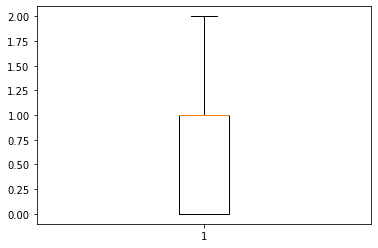

In [ ]:
plt.boxplot(fair_errs_dp_5_counts_1)

### eps=5

In [ ]:
#eps=5
errs_dp_5_counts_1=[]
fair_errs_dp_5_counts_1=[]
for i in range(1000):
  dp_counts_1=syr.add_dp_hist(counts_1,eps=5)
  errs_dp_5_counts_1.append(sum(abs(np.array(dp_counts_1)-counts_1)))
  fair_errs_dp_5_counts_1.append(max(abs(np.array(dp_counts_1)-counts_1))-min(abs(np.array(dp_counts_1)-counts_1)))

In [ ]:
print(errs_dp_5_counts_1)
print(fair_errs_dp_5_counts_1)

[3, 6, 7, 3, 3, 3, 6, 6, 4, 2, 5, 3, 4, 4, 4, 8, 3, 5, 0, 7, 4, 3, 5, 4, 5, 7, 3, 5, 8, 2, 4, 6, 1, 3, 9, 3, 4, 2, 6, 3, 2, 7, 3, 5, 0, 5, 4, 3, 2, 3, 2, 5, 1, 3, 2, 3, 2, 3, 3, 3, 3, 3, 4, 4, 3, 2, 3, 4, 4, 4, 6, 1, 4, 5, 3, 3, 4, 5, 5, 5, 11, 5, 4, 6, 3, 2, 4, 6, 3, 5, 2, 5, 2, 4, 2, 5, 3, 7, 6, 8, 4, 7, 6, 8, 3, 5, 4, 7, 3, 0, 3, 4, 3, 4, 4, 4, 5, 5, 4, 5, 4, 5, 4, 8, 2, 7, 3, 4, 5, 1, 4, 3, 4, 8, 3, 4, 7, 1, 1, 5, 3, 4, 7, 6, 5, 4, 6, 1, 3, 3, 4, 6, 2, 4, 3, 6, 3, 1, 4, 3, 1, 5, 7, 2, 3, 3, 5, 6, 5, 2, 4, 7, 7, 9, 5, 9, 2, 6, 1, 4, 3, 5, 2, 6, 2, 4, 4, 3, 4, 3, 4, 5, 5, 2, 6, 6, 3, 7, 2, 2, 3, 4, 3, 4, 5, 6, 3, 4, 2, 1, 2, 1, 4, 7, 3, 3, 5, 3, 6, 2, 4, 7, 6, 4, 4, 3, 3, 1, 3, 6, 6, 6, 3, 6, 3, 3, 3, 8, 2, 12, 4, 1, 6, 4, 5, 4, 6, 1, 8, 2, 4, 4, 5, 4, 6, 6, 3, 6, 3, 3, 10, 4, 5, 3, 1, 4, 4, 2, 6, 4, 6, 3, 6, 1, 4, 8, 2, 7, 7, 5, 5, 3, 2, 4, 5, 5, 4, 1, 1, 6, 4, 5, 7, 0, 6, 7, 3, 1, 9, 8, 3, 3, 3, 6, 3, 4, 1, 6, 5, 4, 3, 7, 4, 4, 3, 7, 6, 4, 3, 0, 5, 5, 4, 5, 4, 2, 3, 1, 7, 6, 4, 2, 

#### vs Suppression

In [ ]:
dp_better_5_v_k95_l1=0
for i in errs_dp_5_counts_1:
  if i<err_counts_1_adj_95:
    dp_better_5_v_k95_l1+=1
dp_better_5_v_k95_l1=(dp_better_5_v_k95_l1/1000)*100
print(dp_better_5_v_k95_l1)

0.0


In [ ]:
dp_better_5_v_k95_fair=0
for i in fair_errs_dp_5_counts_1:
  if i<fair_err_counts_1_adj_95:
    dp_better_5_v_k95_fair+=1
dp_better_5_v_k95_fair=(dp_better_5_v_k95_fair/1000)*100
print(dp_better_5_v_k95_fair)

0.0


In [ ]:
dp_better_5_v_k90_l1=0
for i in errs_dp_5_counts_1:
  if i<err_counts_1_adj_90:
    dp_better_5_v_k90_l1+=1
dp_better_5_v_k90_l1=(dp_better_5_v_k90_l1/1000)*100
print(dp_better_5_v_k90_l1)

0.0


In [ ]:
dp_better_2_v_k90_fair=0
for i in fair_errs_dp_5_counts_1:
  if i<fair_err_counts_1_adj_87:
    dp_better_2_v_k90_fair+=1
dp_better_2_v_k90_fair=(dp_better_2_v_k90_fair/1000)*100
print(dp_better_2_v_k90_fair)

100.0


In [ ]:
dp_better_1_v_k95_l1=0
for i in errs_dp_5_counts_1:
  if i<err_counts_1_adj_80:
    dp_better_1_v_k95_l1+=1
dp_better_1_v_k95_l1=(dp_better_1_v_k95_l1/1000)*100
print(dp_better_1_v_k95_l1)

100.0


In [ ]:
dp_better_1_v_k95_fair=0
for i in fair_errs_dp_1_counts_1:
  if i<fair_err_counts_1_adj_95:
    dp_better_1_v_k95_fair+=1
dp_better_1_v_k95_fair=(dp_better_1_v_k95_fair/1000)*100
print(dp_better_1_v_k95_fair)

0.0


In [ ]:
dp_better_5_v_k87_l1=0
for i in errs_dp_5_counts_1:
  if i<err_counts_1_adj_87:
    dp_better_5_v_k87_l1+=1
dp_better_5_v_k87_l1=(dp_better_5_v_k87_l1/1000)*100
print(dp_better_5_v_k87_l1)

100.0


In [ ]:
dp_better_5_v_k87_fair=0
for i in fair_errs_dp_5_counts_1:
  if i<fair_err_counts_1_adj_87:
    dp_better_5_v_k87_fair+=1
dp_better_5_v_k87_fair=(dp_better_5_v_k87_fair/1000)*100
print(dp_better_5_v_k87_fair)

100.0


##Random Merging for $k$-Anonymity

In [ ]:
#95th percentile
errs_randomk_95_counts_1=[]
fair_errs_randomk_95_counts_1=[]
for i in range(1000):
  k_counts_1=syr.spread_k_anonymise(counts_1,k=k_95)
  errs_randomk_95_counts_1.append(sum(abs(np.array(k_counts_1)-counts_1)))
  fair_errs_randomk_95_counts_1.append(max(abs(np.array(k_counts_1)-counts_1))-min(abs(np.array(k_counts_1)-counts_1)))

In [ ]:
print(errs_randomk_95_counts_1)
print(fair_errs_randomk_95_counts_1)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [ ]:
#90th percentile
errs_randomk_90_counts_1=[]
fair_errs_randomk_90_counts_1=[]
for i in range(1000):
  k_counts_1=syr.spread_k_anonymise(counts_1,k=k_90)
  errs_randomk_90_counts_1.append(sum(abs(np.array(k_counts_1)-counts_1)))
  fair_errs_randomk_90_counts_1.append(max(abs(np.array(k_counts_1)-counts_1))-min(abs(np.array(k_counts_1)-counts_1)))

In [ ]:
print(errs_randomk_90_counts_1)
print(fair_errs_randomk_90_counts_1)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

{'boxes': [<matplotlib.lines.Line2D at 0x7f659d1775d0>],
 'caps': [<matplotlib.lines.Line2D at 0x7f659d17d690>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f659d1846d0>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7f659d184190>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7f659d177bd0>,
  <matplotlib.lines.Line2D at 0x7f659d17d150>]}

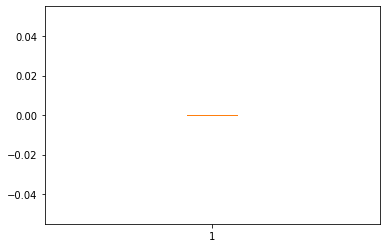

In [ ]:
plt.boxplot(errs_randomk_90_counts_1)

{'boxes': [<matplotlib.lines.Line2D at 0x7f659d0df9d0>],
 'caps': [<matplotlib.lines.Line2D at 0x7f659d0e5a50>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f659d0eea90>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7f659d0ee550>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7f659d0dff90>,
  <matplotlib.lines.Line2D at 0x7f659d0e5510>]}

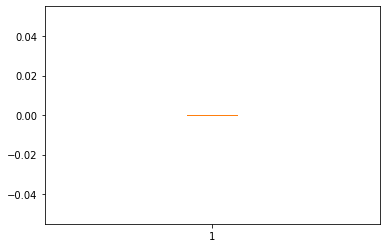

In [ ]:
plt.boxplot(fair_errs_randomk_90_counts_1)

In [ ]:
#87th percentile
errs_randomk_87_counts_1=[]
fair_errs_randomk_87_counts_1=[]
for i in range(1000):
  k_counts_1=syr.spread_k_anonymise(counts_1,k=k_80)
  errs_randomk_87_counts_1.append(sum(abs(np.array(k_counts_1)-counts_1)))
  fair_errs_randomk_87_counts_1.append(max(abs(np.array(k_counts_1)-counts_1))-min(abs(np.array(k_counts_1)-counts_1)))

{'boxes': [<matplotlib.lines.Line2D at 0x7f659d0cd410>],
 'caps': [<matplotlib.lines.Line2D at 0x7f659d0544d0>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f659d05c510>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7f659d054f90>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7f659d0cda10>,
  <matplotlib.lines.Line2D at 0x7f659d0cdf50>]}

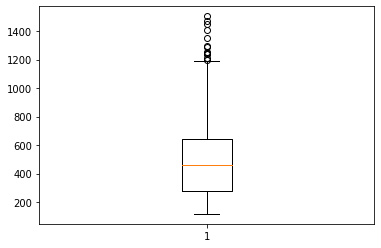

In [ ]:
plt.boxplot(errs_randomk_87_counts_1)

{'boxes': [<matplotlib.lines.Line2D at 0x7f659d03f990>],
 'caps': [<matplotlib.lines.Line2D at 0x7f659d044a10>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f659d049a50>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7f659d049510>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7f659d03ff50>,
  <matplotlib.lines.Line2D at 0x7f659d0444d0>]}

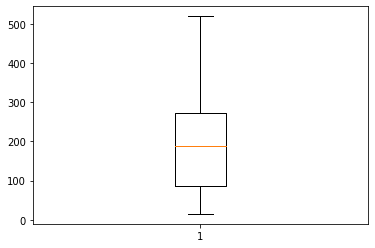

In [ ]:
plt.boxplot(fair_errs_randomk_87_counts_1)

In [ ]:
print(errs_randomk_87_counts_1)
print(fair_errs_randomk_87_counts_1)

[274, 444, 470, 420, 216, 583, 157, 126, 397, 194, 519, 1048, 565, 619, 214, 541, 147, 997, 572, 187, 1072, 193, 867, 632, 1288, 315, 203, 331, 328, 975, 480, 203, 469, 696, 491, 473, 247, 974, 459, 184, 1039, 518, 483, 329, 1296, 201, 954, 401, 574, 384, 667, 664, 637, 925, 294, 294, 117, 323, 685, 1054, 196, 175, 181, 508, 291, 953, 654, 177, 273, 842, 764, 1243, 1188, 354, 728, 448, 274, 876, 599, 485, 506, 397, 508, 241, 831, 286, 1167, 721, 139, 603, 884, 238, 883, 436, 542, 559, 1094, 696, 560, 693, 683, 360, 366, 903, 250, 419, 218, 407, 521, 820, 448, 585, 551, 571, 840, 419, 576, 850, 993, 479, 436, 586, 508, 232, 478, 1120, 325, 1209, 338, 302, 710, 267, 927, 289, 693, 407, 564, 298, 220, 259, 1091, 127, 167, 365, 1156, 1174, 201, 607, 600, 243, 1009, 459, 186, 452, 511, 217, 504, 594, 798, 813, 155, 826, 421, 637, 209, 226, 1052, 572, 387, 612, 747, 664, 217, 520, 538, 400, 507, 615, 367, 221, 183, 621, 269, 719, 309, 366, 159, 635, 258, 238, 819, 477, 562, 377, 353, 228, 75

#Marginal Query 2
Try Poverty Buckets

#Decision Trees on Different PUMAS

In [ ]:
df['PUMA'].unique()

array(['1-1301', '6-8507', '6-7502', '8-803', '13-4600', '17-3529',
       '17-3531', '19-1700', '24-1004', '26-2702', '28-1100', '29-1901',
       '30-600', '32-405', '36-4010', '36-3710', '38-100', '40-200',
       '51-51255', '51-1301'], dtype=object)

## PUMA 1

In [ ]:
df[df['PUMA']=='29-1901']['INCTOT'].value_counts()

0          128
9999999    104
12000       22
50000       14
35000       13
          ... 
291500       1
267000       1
16400        1
44100        1
11960        1
Name: INCTOT, Length: 355, dtype: int64

In [ ]:
puma='38-100'
puma_1_df=df[df['PUMA']==puma]

In [ ]:
puma_1_df

,Unnamed: 0,PUMA,GQ,OWNERSHP,FAMSIZE,NCHILD,AGE,SEX,MARST,RACE,...,INCTOT_DECILE,POVERTY,DENSITY,VETDISAB,DIFFREM,DIFFPHYS,DIFFEYE,DIFFHEAR,HHWT,PERWT
20866,2205687,38-100,4,0,1,0,18,2,6,2,...,3,0,73.0,0,1,1,1,1,54.0,54.0
20867,2205688,38-100,3,0,1,0,34,1,6,1,...,0,0,73.0,0,2,1,1,1,98.0,98.0
20868,2205691,38-100,3,0,1,0,90,2,5,1,...,5,0,73.0,0,2,2,2,2,161.0,161.0
20869,2205693,38-100,3,0,1,0,22,1,6,3,...,1,0,73.0,0,1,1,1,1,31.0,31.0
20870,2205696,38-100,3,0,1,0,84,2,5,1,...,1,0,73.0,0,2,2,1,1,46.0,46.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23159,2213635,38-100,1,2,6,0,1,1,6,1,...,9,384,73.0,0,0,0,1,1,136.0,115.0
23160,2213636,38-100,1,1,2,0,66,1,1,1,...,8,501,73.0,0,1,1,1,1,32.0,33.0
23161,2213637,38-100,1,1,2,0,65,2,1,1,...,1,501,73.0,0,1,1,1,1,32.0,64.0
23162,2213640,38-100,1,1,2,0,55,1,1,1,...,7,501,73.0,0,1,1,1,1,11.0,10.0


In [ ]:
'''
feature_cols=df.columns.tolist()
feature_cols.remove('INCTOT')
feature_cols.remove('PUMA')
feature_cols.remove('INCTOT_DECILE')
feature_cols.remove('INDNAICS')
feature_cols.remove('Unnamed: 0')
X=puma_1_df[feature_cols]
y=puma_1_df['INCTOT']
print(feature_cols)
'''

"\nfeature_cols=df.columns.tolist()\nfeature_cols.remove('INCTOT')\nfeature_cols.remove('PUMA')\nfeature_cols.remove('INCTOT_DECILE')\nfeature_cols.remove('INDNAICS')\nfeature_cols.remove('Unnamed: 0')\nX=puma_1_df[feature_cols]\ny=puma_1_df['INCTOT']\nprint(feature_cols)\n"

In [ ]:
#feature_cols=['OWNERSHP','FAMSIZE','NCHILD','AGE','SEX','RACE','EDUC','SECTOR']
feature_cols=['AGE','FAMSIZE','SEX','RACE','EDUC']
X=puma_1_df[feature_cols]
y=puma_1_df['INCTOT']
print(feature_cols)

['AGE', 'FAMSIZE', 'SEX', 'RACE', 'EDUC']


In [ ]:
X_train, X_test,y_train,y_test=train_test_split(X,y,test_size=0.3)

In [ ]:
np.random.seed(0)
dt_1=DecisionTreeClassifier(random_state=0)
dt_1=dt_1.fit(X_train,y_train)

In [ ]:
y_pred=dt_1.predict(X_test)

In [ ]:
print("Accuracy for PUMA ",puma," is ",metrics.accuracy_score(y_test,y_pred)*100)

Accuracy for PUMA  38-100  is  21.15942028985507


In [ ]:
print(1+dt_1.tree_.max_depth)

28


In [ ]:
def dt_height(tree):
  return max([dt_height(subtree) for subtree in tree.subtrees])

### Demographic %s

In [ ]:
#black
puma_1_df_black=puma_1_df[(puma_1_df['RACE']==2)]# & (puma_1_df['RACE']==2)]
print("Percentage = ",(len(puma_1_df_black.index)/len(puma_1_df)*100))

Percentage =  0.6962576153176675


In [ ]:
#not white
#puma_1_df_nw=puma_1_df[puma_1_df['RACE']!=1]
puma_1_df_nw=puma_1_df[puma_1_df['AGE']>60]
print("Percentage = ",(len(puma_1_df_nw.index)/len(puma_1_df)*100))

Percentage =  27.54569190600522


## PUMA 2

In [ ]:
puma_2_df=df[df['PUMA']=='48-2102']

In [ ]:
puma_2_df

,Unnamed: 0,PUMA,GQ,OWNERSHP,FAMSIZE,NCHILD,AGE,SEX,MARST,RACE,...,INCTOT_DECILE,POVERTY,DENSITY,VETDISAB,DIFFREM,DIFFPHYS,DIFFEYE,DIFFHEAR,HHWT,PERWT


In [ ]:
feature_cols=df.columns.tolist()
feature_cols.remove('INCTOT')
feature_cols.remove('PUMA')
feature_cols.remove('INCTOT_DECILE')
feature_cols.remove('INDNAICS')
feature_cols.remove('Unnamed: 0')
X=puma_2_df[feature_cols]
y=puma_2_df['INCTOT']
print(feature_cols)

['GQ', 'OWNERSHP', 'FAMSIZE', 'NCHILD', 'AGE', 'SEX', 'MARST', 'RACE', 'HISPAN', 'EDUC', 'SECTOR', 'POVERTY', 'DENSITY', 'VETDISAB', 'DIFFREM', 'DIFFPHYS', 'DIFFEYE', 'DIFFHEAR', 'HHWT', 'PERWT']


In [ ]:
#feature_cols=['OWNERSHP','FAMSIZE','NCHILD','AGE','SEX','RACE','EDUC','SECTOR']
feature_cols=['AGE','FAMSIZE','SEX','RACE','EDUC']
X=df[feature_cols]
y=df['INCTOT']
print(feature_cols)

['AGE', 'FAMSIZE', 'SEX', 'RACE', 'EDUC']


In [ ]:
X_train, X_test,y_train,y_test=train_test_split(X,y,test_size=0.3)

In [ ]:
dt_2=DecisionTreeClassifier()
dt_2=dt_2.fit(X_train,y_train)

In [ ]:
y_pred=dt_2.predict(X_test)

In [ ]:
print("Accuracy for PUMA 48-2510 is ",metrics.accuracy_score(y_test,y_pred))

Accuracy for PUMA 48-2510 is  0.22064579256360078


In [ ]:
print(dt_2.tree_.max_depth)

28


In [ ]:
def dt_height(tree):
  return max([dt_height(subtree) for subtree in tree.subtrees])